In [1]:
# pip install tensorflow==2.6.0 coremltools
# pip install coremltools

SyntaxError: invalid syntax (1362686773.py, line 1)

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import coremltools as ct

# Directories for training, validation, and test datasets
train_dir = '/Users/mtsenk/Downloads/train'  # Path to the training dataset
val_dir = '/Users/mtsenk/Downloads/validation'  # Path to the validation dataset
test_dir = '/Users/mtsenk/Downloads/test'  # Path to the test dataset

# Paths for saving the trained model and converted Core ML model
model_save_path = '/Users/mtsenk/Downloads/some/trained_model_2.h5'  # Save path for the Keras model
mlmodel_save_path = '/Users/mtsenk/Downloads/some/trained_model_2.mlmodel'  # Save path for Core ML model


img_size = 224  # Image size to which all images will be resized (224x224 pixels)
batch_size = 32  # Number of images in each batch during training and testing
epochs = 95  # Maximum number of training epochs
learning_rate = 0.0001  # Learning rate for the optimizer

# Data generator for training images with augmentation to improve model robustness
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalize pixel values to the range [0, 1]
    rotation_range=30,  # Randomly rotate images up to 30 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by up to 20%
    height_shift_range=0.2,  # Randomly shift images vertically by up to 20%
    shear_range=0.2,  # Apply random shear transformations
    zoom_range=0.2,  # Randomly zoom in or out by up to 20%
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode="nearest"  # Fill missing pixels after transformations using the nearest pixel
)

# Data generator for validation images 
val_datagen = ImageDataGenerator(rescale=1.0/255)

# Data generator for test images 
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Generator for training data
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Path to the training dataset
    target_size=(img_size, img_size),  # Resize all images to 224x224 pixels
    batch_size=batch_size,  # Process images in batches of 32
    class_mode='categorical'  # Output labels one-hot encoded
)

# Generator for validation data
val_generator = val_datagen.flow_from_directory(
    val_dir,  # Path to the validation dataset
    target_size=(img_size, img_size),  # Resize all images to 224x224 pixels
    batch_size=batch_size,  # Process images in batches of 32
    class_mode='categorical'  # Output labels one-hot encoded
)

# Generator for test data
test_generator = test_datagen.flow_from_directory(
    test_dir,  # Path to the test dataset
    target_size=(img_size, img_size),  # Resize all images to 224x224 pixels
    batch_size=batch_size,  # Process images in batches of 32
    class_mode='categorical'  # Output labels will be one-hot encoded
)

Found 6613 images belonging to 19 classes.
Found 2197 images belonging to 19 classes.
Found 2205 images belonging to 19 classes.


In [2]:
# Create the base model using MobileNetV2
base_model = MobileNetV2(
    input_shape=(img_size, img_size, 3),  # Define the input shape (224x224 RGB images)
    include_top=False,  # Exclude the top layers of the pre-trained model
    weights='imagenet'  # Load pre-trained weights from the ImageNet dataset
)

# Freeze the base model
base_model.trainable = False  # Prevent the weights of the base model from being updated during training

Metal device set to: Apple M1 Pro


In [3]:
# Add custom layers on top of the base model
x = base_model.output  # Use the output of the base MobileNetV2 model as the input for the custom layers

# Add a Global Average Pooling layer
x = GlobalAveragePooling2D()(x)  # Reduces the spatial dimensions of the feature maps to a single vector per channel

# Add a dense layer with 128 units and ReLU activation
x = Dense(128, activation='relu')(x)  # Introduces learnable parameters to combine the extracted features

# Add a Dropout layer to reduce overfitting
x = Dropout(0.5)(x)  # Randomly sets 50% of the input units to zero during training to prevent overfitting

# Add the final output layer for classification
output = Dense(train_generator.num_classes, activation='softmax')(x)  
# train_generator.num_classes: Determines the number of output classes dynamically
# softmax: Converts the output into probabilities for each class

# Create the final model by combining the base model and custom layers
model = Model(inputs=base_model.input, outputs=output)
# inputs=base_model.input: Input to the model is the same as the base model's input
# outputs=output: The final output is the custom classification layer


In [4]:
# Train the model
history = model.fit(
    train_generator,  # Training data generator that yields batches of images and labels
    epochs=epochs,  # Number of epochs 
    validation_data=val_generator  # Validation data generator for evaluating the model at the end of each epoch
)

# Save the trained model to the specified path
model.save(model_save_path)  # Save the model in Keras H5 format
print(f"Model saved to {model_save_path}")  # Confirm the save location

Epoch 1/95
 32/207 [===>..........................] - ETA: 1:36 - loss: 3.1403 - accuracy: 0.1055

/Users/mtsenk/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


207/207 [==============================] - 146s 699ms/step - loss: 2.5221 - accuracy: 0.2545 - val_loss: 1.8278 - val_accuracy: 0.5184
Epoch 2/95
207/207 [==============================] - 141s 682ms/step - loss: 1.7724 - accuracy: 0.4568 - val_loss: 1.3154 - val_accuracy: 0.6668
Epoch 3/95
207/207 [==============================] - 135s 653ms/step - loss: 1.4053 - accuracy: 0.5634 - val_loss: 1.0633 - val_accuracy: 0.7255
Epoch 4/95
207/207 [==============================] - 134s 647ms/step - loss: 1.2139 - accuracy: 0.6204 - val_loss: 0.9183 - val_accuracy: 0.7615
Epoch 5/95
207/207 [==============================] - 136s 655ms/step - loss: 1.0631 - accuracy: 0.6646 - val_loss: 0.8177 - val_accuracy: 0.7761
Epoch 6/95
207/207 [==============================] - 134s 647ms/step - loss: 0.9659 - accuracy: 0.7020 - val_loss: 0.7559 - val_accuracy: 0.7934
Epoch 7/95
207/207 [==============================] - 135s 654ms/step - loss: 0.8966 - accuracy: 0.7160 - val_loss: 0.6982 - val_accura

In [5]:
def unfreeze_layers(base_model, unfreeze_from_layer):
    """
    Unfreezes all layers in the base model starting from the specified layer.

    Parameters:
    - base_model: The pre-trained model whose layers will be unfrozen.
    - unfreeze_from_layer: The name of the layer from which to start unfreezing.
    """
    set_trainable = False  # Tracks whether layers should be made trainable
    for layer in base_model.layers:
        if layer.name == unfreeze_from_layer:
            set_trainable = True  # Begin unfreezing layers once the target layer is found
        layer.trainable = set_trainable  # Set the layer's trainability based on the flag


# Unfreeze layers starting from 'block_13_expand' in the base model
unfreeze_from_layer = 'block_13_expand'
unfreeze_layers(base_model, unfreeze_from_layer)

# Compile the model with a lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate / 10),  # Reduce learning rate to avoid drastic updates
    loss='categorical_crossentropy',  # Loss function for multiclass classification
    metrics=['accuracy']  # Track accuracy during training and evaluation
)

# Compute class weights to handle imbalanced classes in the dataset
class_weights_array = compute_class_weight(
    class_weight='balanced',  # Balances weights based on class frequencies
    classes=np.unique(train_generator.classes),  # Unique class labels
    y=train_generator.classes  # Actual labels for training data
)
class_weights = dict(enumerate(class_weights_array))  # Convert array to dictionary with class indices as keys

history_fine = model.fit(
    train_generator,  # Training data generator
    epochs=epochs + 5,  # Extend training by 5 epochs
    initial_epoch=history.epoch[-1],  # Start from the last completed epoch in the previous training
    validation_data=val_generator,  # Validation data generator
    class_weight=class_weights  # Use class weights to handle imbalanced data
)


model.save(model_save_path)  # Save the model to the specified file path
print(f"Model saved to {model_save_path}")  # Confirm the model save location

next_unfreeze_layer = 'block_10_expand'
unfreeze_layers(base_model, next_unfreeze_layer)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_fine_tune2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    class_weight=class_weights
)

model.save(model_save_path)
print(f"Model saved to {model_save_path}")


Epoch 95/100
207/207 [==============================] - 136s 646ms/step - loss: 0.7953 - accuracy: 0.7632 - val_loss: 0.3734 - val_accuracy: 0.8785
Epoch 96/100
207/207 [==============================] - 135s 651ms/step - loss: 0.5764 - accuracy: 0.8243 - val_loss: 0.3717 - val_accuracy: 0.8798
Epoch 97/100
207/207 [==============================] - 134s 646ms/step - loss: 0.4914 - accuracy: 0.8388 - val_loss: 0.3636 - val_accuracy: 0.8844
Epoch 98/100
207/207 [==============================] - 134s 646ms/step - loss: 0.4468 - accuracy: 0.8589 - val_loss: 0.3590 - val_accuracy: 0.8862
Epoch 99/100
207/207 [==============================] - 138s 666ms/step - loss: 0.4193 - accuracy: 0.8681 - val_loss: 0.3499 - val_accuracy: 0.8880
Epoch 100/100
207/207 [==============================] - 134s 645ms/step - loss: 0.3729 - accuracy: 0.8805 - val_loss: 0.3636 - val_accuracy: 0.8876
Model saved to /Users/mtsenk/Downloads/some/trained_model_2.h5
Epoch 1/5
207/207 [=============================

In [6]:

# Оценка модели
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")


69/69 [==============================] - 26s 369ms/step - loss: 0.3412 - accuracy: 0.8934
Test Accuracy: 0.8934240341186523


In [10]:
# Сохранение финальной модели
# model.save(model_save_path)
# print(f"Final model saved to {model_save_path}")

# Конвертация в Core ML (.mlmodel)
mlmodel = ct.convert(
    model,
    inputs=[ct.ImageType(shape=(1, img_size, img_size, 3), scale=1.0/255)],
    convert_to='neuralnetwork',
    minimum_deployment_target=ct.target.iOS14
)
mlmodel.save(mlmodel_save_path)

print(f"Core ML model saved to {mlmodel_save_path}")

Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 491/491 [00:00<00:00, 3456.49 ops/s]


Core ML model saved to /Users/mtsenk/Downloads/some/trained_model_2.mlmodel


 1/69 [..............................] - ETA: 31s

/Users/mtsenk/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


69/69 [==============================] - 25s 359ms/step


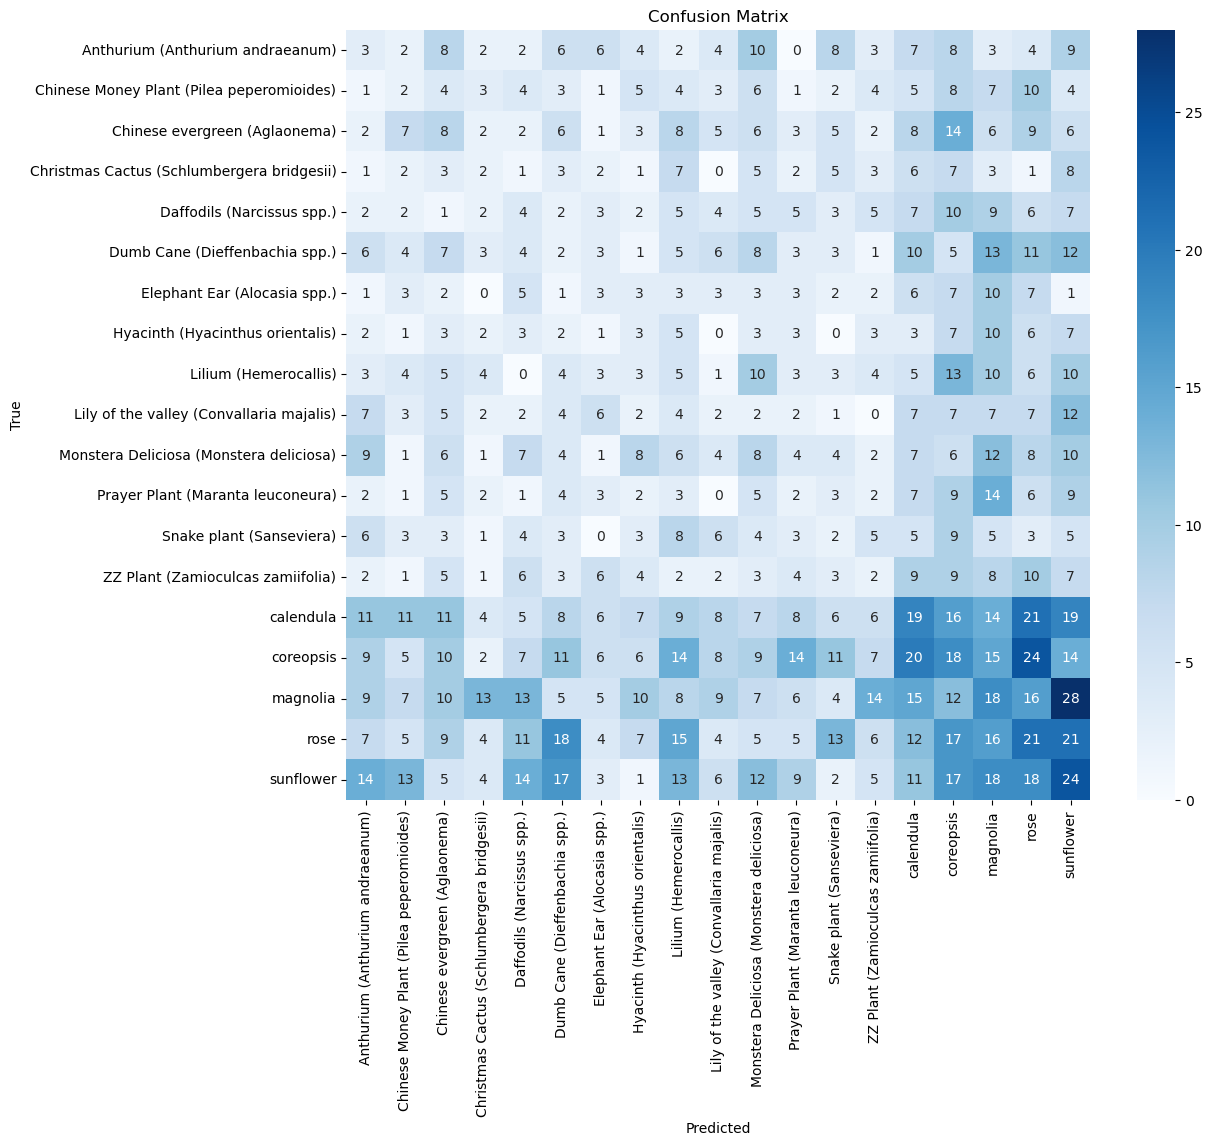

In [13]:
import numpy as np

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1) 
y_true = test_generator.classes  
class_names = list(test_generator.class_indices.keys()) 
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred_classes)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()